In [1]:
import os
import tensorflow as tf
from google.protobuf import text_format
from protos import pipeline_pb2
from modeling import trainer

image_dir = "/afs/cs.pitt.edu/usr0/key36/work2/WSSGG/data-vspnet/images"
model_dir = "/afs/cs.pitt.edu/usr0/key36/work2/WSSGG/logs.basic.trainwv/rnn_it3_lyr2/"
config_file = os.path.join(model_dir, "pipeline.pbtxt")

nms_iou_threshold = 0.3

for gpu in tf.config.experimental.list_physical_devices('GPU'):
  tf.config.experimental.set_memory_growth(gpu, True)

with tf.io.gfile.GFile(config_file, 'r') as fp: 
  pipeline_proto = text_format.Merge(
      fp.read().replace('iou_thresh: 0.4', 'iou_thresh: %.1lf' % nms_iou_threshold), 
      pipeline_pb2.Pipeline())
batch_generator = trainer.predict(pipeline_proto, model_dir)

{('banana', 'head'): Text(0.7499999850988388, 0.43301273385683725, 'on'),
 ('banana', 'hand'): Text(0.7499999552965164, -0.43301271398862173, 'in'),
 ('girl', 'banana'): Text(0.2499999701976776, 0.43301270405451486, 'hold'),
 ('girl', 'shirt'): Text(-0.7500000298023224, 0.43301266034312746, 'wear'),
 ('girl', 'hair'): Text(-0.4999999850988388, -2.9802322387695312e-08, 'have')}

<Figure size 1152x576 with 0 Axes>

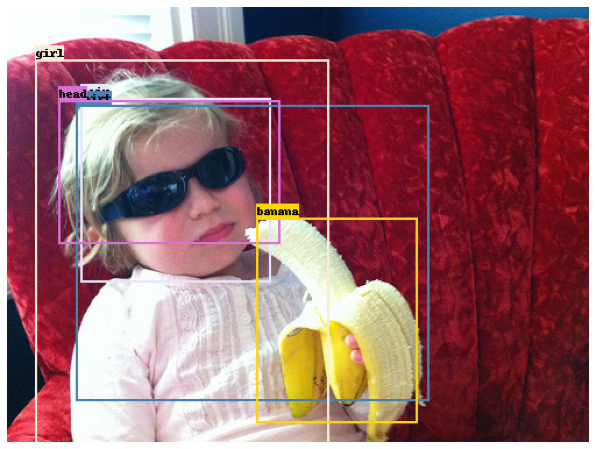

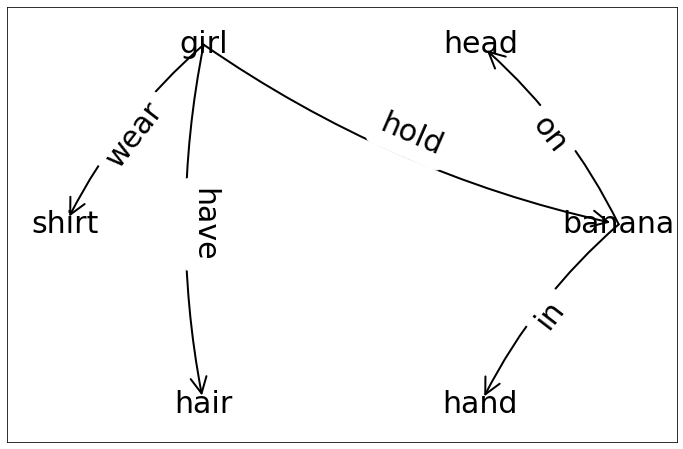

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import networkx as nx
from modeling.utils import visualization
from modeling.utils.box_ops import py_iou

%matplotlib inline

try:
  i = next(example_id_generator)
except Exception as ex:
  example = next(batch_generator)
  example_id_generator = (i for i in range(len(example['id'])))
  i = next(example_id_generator)


# Predictions.
scope = 'beam/'
image_id = example['id'][i]
n_triple = example[scope + 'n_triple'][i]
subjects = example[scope + 'subject'][i]
subject_boxes = example[scope + 'subject/box'][i]
predicates = example[scope + 'predicate'][i]
objects = example[scope + 'object'][i]
object_boxes = example[scope + 'object/box'][i]

# Load original image.
image = Image.open(os.path.join(image_dir, '%i.jpg' % image_id))
image = np.array(image)

entity_names = []  # Name with seqId, e.g., horse, cat, person:0, person:1.
entity_boxes = []
g = nx.DiGraph()

def _insert_entity(box, name):
  name = name.decode('ascii')
  seq_id = 0
  for i in range(len(entity_names)):
    if name == entity_names[i].split(':')[0] and py_iou(box, entity_boxes[i]) > 0.5:
      return i
    if name == entity_names[i].split(':')[0]:
      seq_id += 1
  if seq_id == 0:
    entity_names.append(name)
  else:
    entity_names.append(name + ':%i' % seq_id)
  entity_boxes.append(box)
  return len(entity_names) - 1

plt.figure(figsize=(16, 8))

count = 0
for (sub, sub_box, pred, obj, obj_box) in zip(
    subjects, subject_boxes, predicates, objects, object_boxes):
  if count >=5: break
  sub_id = _insert_entity(sub_box, sub)
  obj_id = _insert_entity(obj_box, obj)
    
  edge = pred
  from_node = entity_names[sub_id]
  to_node = entity_names[obj_id]
  g.add_edge(from_node, to_node, label=edge.decode('ascii'), weight=0)
  count += 1

# Show image with detected entities.
plt.figure(figsize=(12, 8))
image_with_detections = visualization.draw_bounding_box_py_func_fn(
    image, len(entity_names), entity_boxes, entity_names, None, 2)
plt.imshow(image)
plt.axis('off')

# Show graph.
plt.figure(figsize=(12, 8))
pos = nx.shell_layout(g)
nx.draw_networkx_nodes(g, pos, node_size=0, node_shape='o', node_color='#1f78b4')
nx.draw_networkx_labels(g, pos, font_size=30, font_family='sans-serif')
nx.draw_networkx_edges(g, pos, arrowsize=40, width=2, draw_networkx_edges=True, 
                       arrowstyle='->', connectionstyle='arc3, rad=0.1')
nx.draw_networkx_edge_labels(
    g, pos, font_size=30, edge_labels=dict([((u, v), d['label']) for u, v, d in g.edges(data=True)]))